In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [3]:
df=pd.read_csv("214_Temp.csv")

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [5]:
df.dropna(inplace=True)

In [6]:
ts=df.loc['1/15/2020':'2/15/2020']['Temperature']
#ts=pd.DataFrame(ts)
ts.tail()

Date
2020-02-15 15:50:00    61.8
2020-02-15 17:50:00    66.0
2020-02-15 19:50:00    67.4
2020-02-15 21:50:00    68.1
2020-02-15 23:50:00    67.1
Name: Temperature, dtype: float64

In [7]:
ts.shape

(384,)

# 1st approach

In [8]:
# Create Training and Test
train = ts[:288]
test = ts[288:]

In [57]:
#building the model
import pmdarima as pm
from pmdarima.arima import auto_arima

model = pm.auto_arima(train, start_p=1, start_q=1, seasonal=True, m=12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sa

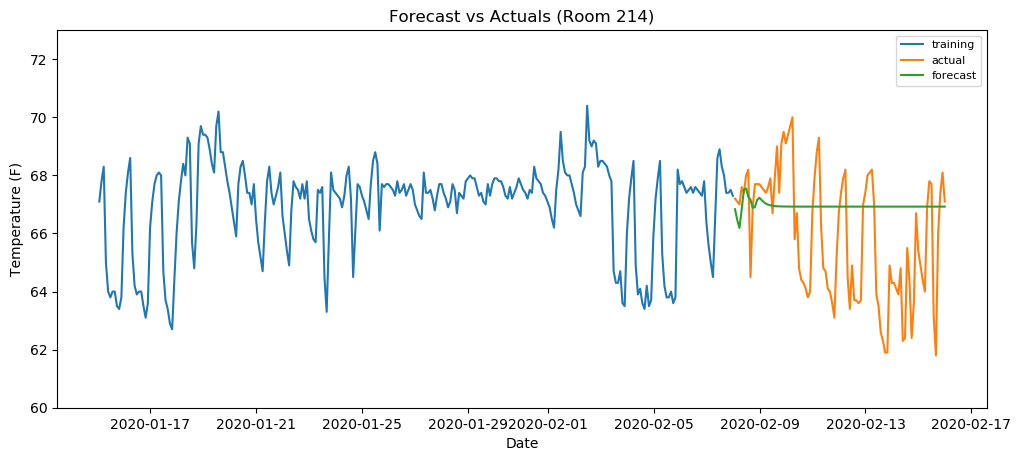

RMSE: 2.3703


In [59]:
# make your forecasts
forecasts = model.predict(96)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:288],train.values, label='training')
plt.plot(ts.index[288:],test.values, label='actual')
plt.plot(ts.index[288:],forecasts, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 214)')
plt.legend(loc='best', fontsize=8)
plt.ylim(60,73)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

print('RMSE: %.4f'% np.sqrt(sum((test.values-forecasts)**2)/len(forecasts)))

# 2nd approach

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


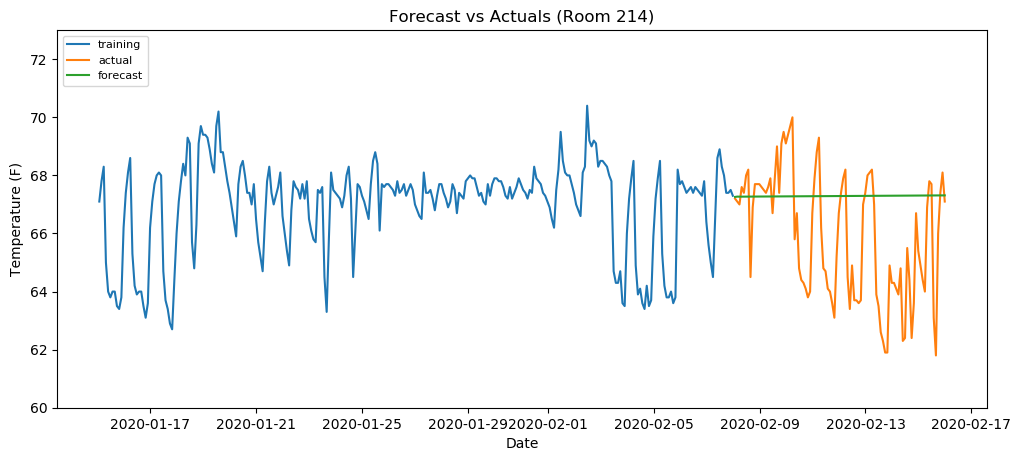

In [60]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(96, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 214)')
plt.legend(loc='upper left', fontsize=8)
plt.ylim(60,73)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

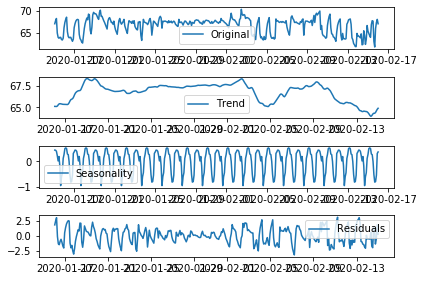

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
print('RMSE: %.4f'% np.sqrt(sum((fc_series-test)**2)/len(fc_series)))

RMSE: 2.5557


# 3rd approach

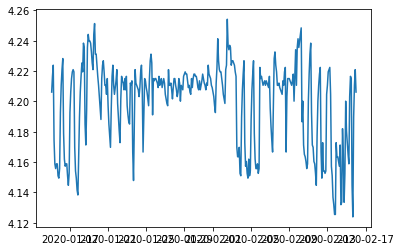

In [13]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

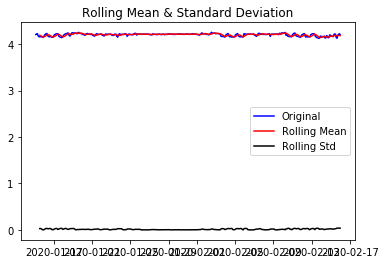

Results of Dickey-Fuller Test:
Test Statistic                  -3.029789
p-value                          0.032205
#Lags Used                      17.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [15]:
test_stationarity(ts_log)

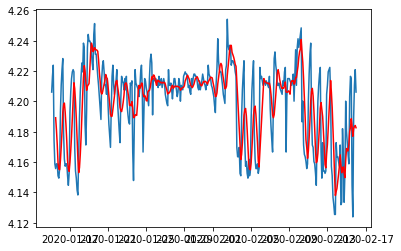

In [16]:
moving_avg = ts_log.rolling(6).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_moving_avg_diff=ts_log-moving_avg
ts_moving_avg_diff.dropna(inplace=True)
ts_moving_avg_diff.head()

Date
2020-01-15 11:50:00   -0.033527
2020-01-15 13:50:00   -0.022513
2020-01-15 15:50:00   -0.012900
2020-01-15 17:50:00   -0.008598
2020-01-15 19:50:00   -0.006021
Name: Temperature, dtype: float64

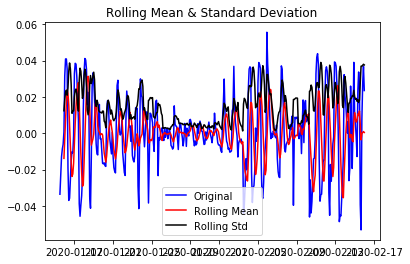

Results of Dickey-Fuller Test:
Test Statistic                  -4.922071
p-value                          0.000032
#Lags Used                      17.000000
Number of Observations Used    361.000000
Critical Value (1%)             -3.448595
Critical Value (5%)             -2.869580
Critical Value (10%)            -2.571053
dtype: float64


In [18]:
test_stationarity(ts_moving_avg_diff)

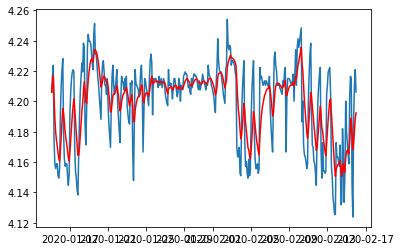

In [19]:
expwighted_avg = ts_log.ewm(halflife=3).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

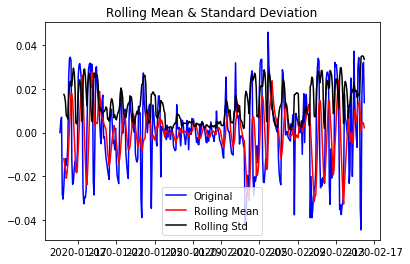

Results of Dickey-Fuller Test:
Test Statistic                  -5.028943
p-value                          0.000019
#Lags Used                      12.000000
Number of Observations Used    371.000000
Critical Value (1%)             -3.448100
Critical Value (5%)             -2.869362
Critical Value (10%)            -2.570937
dtype: float64


In [20]:
ts_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_ewma_diff)

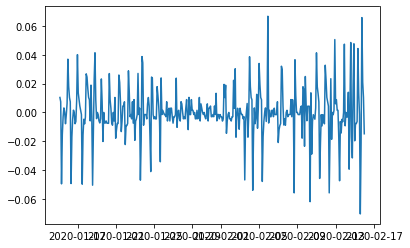

In [21]:
ts_diff=ts_log-ts_log.shift()
plt.plot(ts_diff)

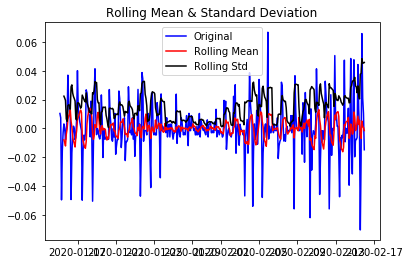

Results of Dickey-Fuller Test:
Test Statistic                -8.061367e+00
p-value                        1.639612e-12
#Lags Used                     1.100000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


In [22]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [23]:
#ts_diff=ts_diff-ts_diff.shift()
#plt.plot(ts_diff)

In [24]:
#ts_diff.dropna(inplace=True)
#test_stationarity(ts_diff)

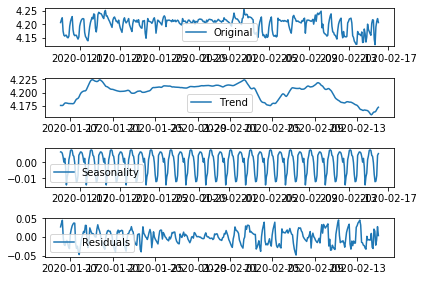

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

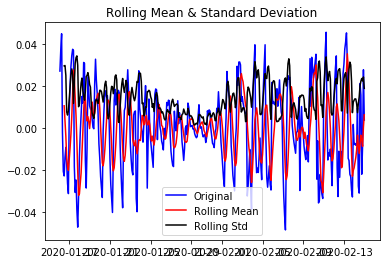

Results of Dickey-Fuller Test:
Test Statistic                -7.398490e+00
p-value                        7.665280e-11
#Lags Used                     1.300000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64


In [26]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

In [27]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [28]:
lag_acf = acf(ts_diff, nlags=6)
lag_pacf = pacf(ts_diff, nlags=6, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

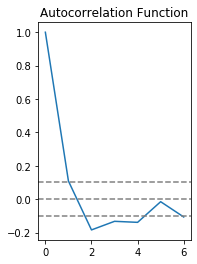

In [29]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

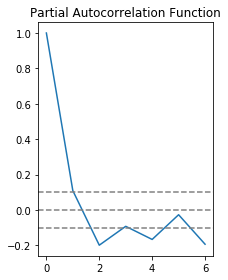

In [30]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [31]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1143')

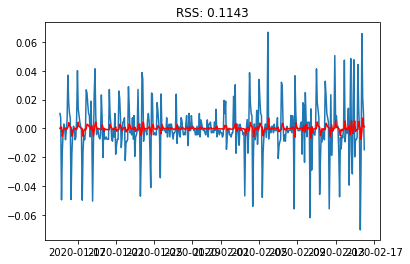

In [32]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)
a=results_AR.fittedvalues
a.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(a, color='red')
plt.title('RSS: %.4f'% sum((a-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1136')

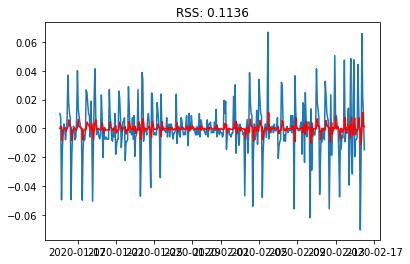

In [33]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)
b=results_MA.fittedvalues
b.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(b, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1047')

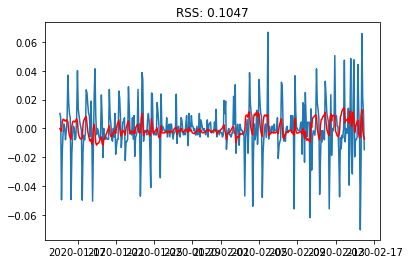

In [34]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
c=results_ARIMA.fittedvalues
c.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(c, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

In [35]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  383
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1028.051
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 07 May 2020   AIC                          -2048.101
Time:                        14:08:31   BIC                          -2032.309
Sample:                    01-15-2020   HQIC                         -2041.837
                         - 02-15-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.968e-05   5.83e-05     -0.680      0.496      -0.000    7.47e-05
ar.L1.D.Temperature     0.7799      0.047     16.428      0.000       0.687       0.873
ma.L1.D.Temperat

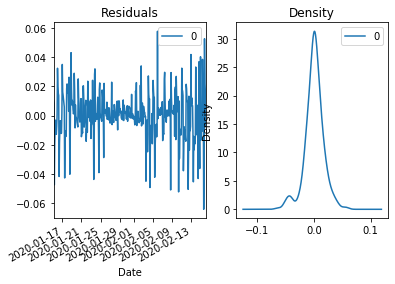

In [36]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [37]:
#results_ARIMA.plot_predict(dynamic=False)
#plt.show()

In [38]:
#AR forecast

In [39]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff.head()

Date
2020-01-15 03:50:00   -0.000001
2020-01-15 05:50:00    0.001131
2020-01-15 07:50:00    0.000801
2020-01-15 09:50:00   -0.005406
2020-01-15 11:50:00   -0.001693
dtype: float64

In [40]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_diff_cumsum.head()

Date
2020-01-15 03:50:00   -0.000001
2020-01-15 05:50:00    0.001130
2020-01-15 07:50:00    0.001931
2020-01-15 09:50:00   -0.003476
2020-01-15 11:50:00   -0.005169
dtype: float64

In [41]:
predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:50:00    4.206184
2020-01-15 03:50:00    4.206183
2020-01-15 05:50:00    4.207314
2020-01-15 07:50:00    4.208115
2020-01-15 09:50:00    4.202708
dtype: float64

Text(0, 0.5, 'Temperature (F)')

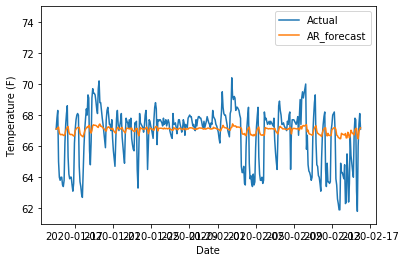

In [42]:
predictions_AR = np.exp(predictions_AR_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_AR,label='AR_forecast')
plt.legend(loc="upper right")
plt.ylim(61,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [43]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))

RMSE: 1.6713


In [44]:
#MA forecast

In [45]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_MA_diff.head()

Date
2020-01-15 03:50:00   -0.000004
2020-01-15 05:50:00    0.001658
2020-01-15 07:50:00    0.000931
2020-01-15 09:50:00   -0.008296
2020-01-15 11:50:00   -0.001188
dtype: float64

In [46]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA_diff_cumsum.head()

Date
2020-01-15 03:50:00   -0.000004
2020-01-15 05:50:00    0.001654
2020-01-15 07:50:00    0.002585
2020-01-15 09:50:00   -0.005711
2020-01-15 11:50:00   -0.006899
dtype: float64

In [47]:
predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:50:00    4.206184
2020-01-15 03:50:00    4.206180
2020-01-15 05:50:00    4.207838
2020-01-15 07:50:00    4.208769
2020-01-15 09:50:00    4.200473
dtype: float64

Text(0, 0.5, 'Temperature (F)')

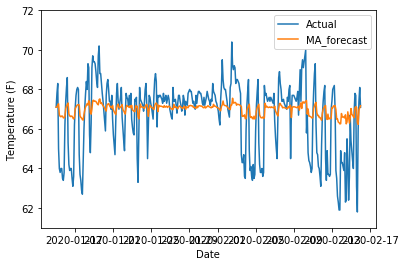

In [48]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_MA,label='MA_forecast')
plt.legend(loc="upper right")
plt.ylim(61,72)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [49]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))

RMSE: 1.6101


In [50]:
#ARIMA forecast

In [51]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2020-01-15 03:50:00   -0.000040
2020-01-15 05:50:00   -0.001184
2020-01-15 07:50:00   -0.001961
2020-01-15 09:50:00    0.004624
2020-01-15 11:50:00    0.006354
dtype: float64

In [52]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2020-01-15 03:50:00   -0.000040
2020-01-15 05:50:00   -0.001223
2020-01-15 07:50:00   -0.003185
2020-01-15 09:50:00    0.001439
2020-01-15 11:50:00    0.007793
dtype: float64

In [53]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:50:00    4.206184
2020-01-15 03:50:00    4.206144
2020-01-15 05:50:00    4.204961
2020-01-15 07:50:00    4.202999
2020-01-15 09:50:00    4.207623
dtype: float64

Text(0, 0.5, 'Temperature (F)')

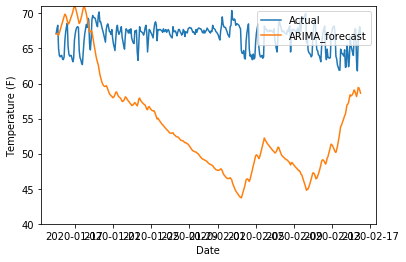

In [54]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_ARIMA,label='ARIMA_forecast')
plt.legend(loc="upper right")
plt.ylim(40,71)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [55]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

RMSE: 14.7214
